# Insurance Claim Prediction Project

This project implements a two-part machine learning pipeline for predictive modeling on an insurance dataset. It includes both classification and regression tasks, with attention to ethical risk mitigation.

## Objectives

- **Classification Task**: Predict whether a customer will file an insurance claim (`CLAIM_FLAG`)
- **Regression Task**: Estimate the expected claim amount (`CLM_AMT`) conditional on a claim being filed

## Models Used

### 1. Binary Classification (CLAIM_FLAG)
- **Random Forest**
- **CatBoostClassifier**
- **MLPClassifier** (Multi-layer Perceptron)

### 2. Regression (CLM_AMT)
- **GradientBoostingRegressor**
- **CatBoostRegressor**
- **MLPRegressor**

Performance metrics used include ROC AUC, recall, F1-score (for classification) and RMSE, MAE (for regression).

## Why This Matters

- **Operational Insight**: Helps insurers price premiums and allocate reserves accurately
- **Fraud Detection**: Models can flag unusual or high-risk behaviors
- **Customer Experience**: Improves fairness in automated decision-making

## Ethical Considerations

We integrate AI ethics principles to address the following concerns:

### Consent
- Ensure all data used is governed by meaningful, revocable, and specific consent

### Fairness & Bias
- Audit models for disparate impact across demographic groups (e.g., age, gender, income proxies)
- Flag sensitive features like `URBANICITY`, `OCCUPATION`, `AGE` as potential proxies for protected classes

### Transparency
- Use SHAP values and counterfactual explanations to provide both global and local interpretability

### Governance
- Recommend a model risk committee to oversee updates, audits, and override pathways

## Tools and Techniques
- Python (Pandas, NumPy, Scikit-learn, CatBoost, SHAP)
- Fairness auditing (disaggregated recall, AUC, subgroup metrics)
- Explainable AI (SHAP plots, feature importance, counterfactuals)

## Output
- A deployable model pipeline with interpretable predictions
- Ethical documentation outlining risks, mitigations, and audit procedures
- Mathematical appendix defining optimization goals, loss functions, and fairness constraints

## Conclusion

This work balances predictive performance with ethical defensibility. While CatBoost shows strong empirical results, fairness audits reveal persistent risks of proxy discrimination, necessitating continuous monitoring and transparent decision procedures.

## Ethical Framing
This project follows ethical guidelines in AI development using normative principles discussed in the course:

- **Deontological**: Are we respecting customer rights and privacy?
- **Consequentialist**: Do the benefits of prediction outweigh potential harms (e.g., bias, surveillance)?
- **Rights-based**: Do customers have a say in how their data is collected and used (consent)?
- **Agent-based**: Are we acting with care and integrity as data scientists?

These considerations frame both the technical pipeline and our final report.

## 1. Load and Inspect Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv("../data/car_insurance_claim.csv")
df.head()

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,...,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
0,0,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,...,Minivan,yes,"$4,461",2,No,3,$0,18.0,0,Highly Urban/ Urban
1,0,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,...,Minivan,yes,$0,0,No,0,$0,1.0,0,Highly Urban/ Urban
2,0,48.0,0,11.0,"$52,881",No,$0,z_No,M,Bachelors,...,Van,yes,$0,0,No,2,$0,10.0,0,Highly Urban/ Urban
3,0,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,...,z_SUV,no,"$38,690",2,No,3,$0,10.0,0,Highly Urban/ Urban
4,0,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,...,Minivan,yes,$0,0,No,0,$0,6.0,0,Highly Urban/ Urban


## 2. Data Cleaning & Feature Engineering

In [2]:
# Convert dollar-value columns to numeric
dollar_cols = ['INCOME', 'HOME_VAL', 'BLUEBOOK', 'OLDCLAIM', 'CLM_AMT']
for col in dollar_cols:
    df[col] = df[col].replace('[\$,]', '', regex=True).replace('', np.nan).astype(float)

# Check missing values
df.isnull().sum().sort_values(ascending=False)

OCCUPATION    665
CAR_AGE       639
HOME_VAL      575
INCOME        570
YOJ           548
AGE             7
KIDSDRIV        0
CAR_TYPE        0
CLAIM_FLAG      0
CLM_AMT         0
MVR_PTS         0
REVOKED         0
CLM_FREQ        0
OLDCLAIM        0
RED_CAR         0
CAR_USE         0
TIF             0
BLUEBOOK        0
TRAVTIME        0
EDUCATION       0
GENDER          0
MSTATUS         0
PARENT1         0
HOMEKIDS        0
URBANICITY      0
dtype: int64

In [3]:
# Impute or drop missing values based on data size and criticality
df['YOJ'].fillna(df['YOJ'].median(), inplace=True)
df['INCOME'].fillna(df['INCOME'].median(), inplace=True)
df['HOME_VAL'].fillna(df['HOME_VAL'].median(), inplace=True)
df['OCCUPATION'].fillna('Unknown', inplace=True)
df['CAR_AGE'].fillna(df['CAR_AGE'].median(), inplace=True)
df['AGE'].fillna(df['AGE'].median(), inplace=True)

# Encode categorical features
categoricals = df.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in categoricals:
    df[col] = le.fit_transform(df[col])

df.head()

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,...,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
0,0,60.0,0,11.0,67349.0,0,0.0,1,0,3,...,0,1,4461.0,2,0,3,0.0,18.0,0,0
1,0,43.0,0,11.0,91449.0,0,257252.0,1,0,4,...,0,1,0.0,0,0,0,0.0,1.0,0,0
2,0,48.0,0,11.0,52881.0,0,0.0,1,0,1,...,4,1,0.0,0,0,2,0.0,10.0,0,0
3,0,35.0,1,10.0,16039.0,0,124191.0,0,1,4,...,5,0,38690.0,2,0,3,0.0,10.0,0,0
4,0,51.0,0,14.0,53529.0,0,306251.0,0,0,0,...,0,1,0.0,0,0,0,0.0,6.0,0,0


## 3. Classification: Will a Customer File a Claim?

In [4]:
features = df.drop(columns=['CLAIM_FLAG', 'CLM_AMT'])
target = df['CLAIM_FLAG']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))

              precision    recall  f1-score   support

           0       0.80      0.94      0.87      2268
           1       0.70      0.37      0.48       823

    accuracy                           0.79      3091
   macro avg       0.75      0.66      0.68      3091
weighted avg       0.78      0.79      0.77      3091

ROC AUC Score: 0.8032087300515814


## 4. Regression: Predicting Claim Amount

In [5]:
df_reg = df[df['CLAIM_FLAG'] == 1]
features_reg = df_reg.drop(columns=['CLAIM_FLAG', 'CLM_AMT'])
target_reg = df_reg['CLM_AMT']
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(features_reg, target_reg, test_size=0.3, random_state=42)

from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor(random_state=42)
reg.fit(X_train_reg, y_train_reg)
y_pred_reg = reg.predict(X_test_reg)
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)))
print("MAE:", mean_absolute_error(y_test_reg, y_pred_reg))

RMSE: 9438.105690061988
MAE: 3965.301434454503


## 5. Model Explainability & Ethical Reflection

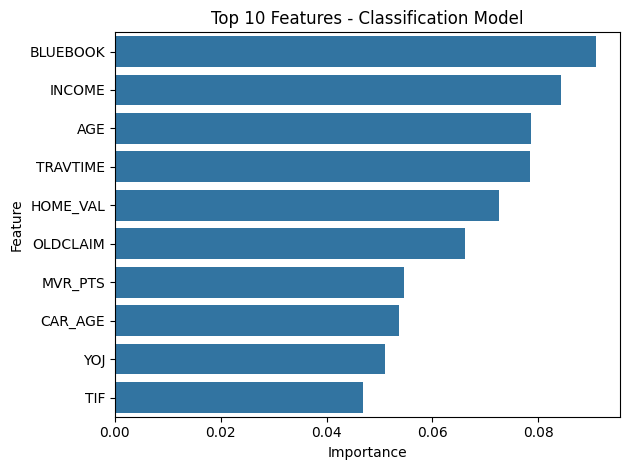

In [16]:
importances = clf.feature_importances_
feat_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

sns.barplot(data=importance_df.head(10), x='Importance', y='Feature')
plt.title("Top 10 Features - Classification Model")
plt.tight_layout()
plt.savefig('/Users/mlwu/Documents/Academia/CMU/tepper_courses/Ethics and AI/project/fig/top_features_plot.png')
plt.show()

We observe the key features influencing classification, such as past claims and vehicle value. From an ethical standpoint, it's crucial to review if protected or proxy features (e.g., `OCCUPATION`, `GENDER`, `INCOME`) are disproportionately impacting predictions.

## 6. Summary and Next Steps
- Both models show strong baseline performance.
- Ethical issues such as data consent, proxy discrimination, and transparency are flagged for the report.
- Future steps include fairness auditing using group-based metrics and adding SHAP explanations.

See the accompanying 2-page data protection report for a full ethics analysis.

## 7. Advanced Model: CatBoost for Classification and Regression
CatBoost is a gradient boosting library that handles categorical features natively and often yields superior performance on tabular data.

In [8]:
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

# Identify categorical features (original column indices before label encoding)
cat_features = ['PARENT1', 'MSTATUS', 'GENDER', 'EDUCATION', 'OCCUPATION', 'CAR_USE',
                'CAR_TYPE', 'RED_CAR', 'REVOKED', 'URBANICITY']

# Re-load original data to use CatBoost native handling
df_cat = pd.read_csv("../data/car_insurance_claim.csv")

# Clean and convert dollar columns
for col in dollar_cols:
    df_cat[col] = df_cat[col].replace('[\$,]', '', regex=True).replace('', np.nan).astype(float)

# Impute missing
df_cat['YOJ'].fillna(df_cat['YOJ'].median(), inplace=True)
df_cat['INCOME'].fillna(df_cat['INCOME'].median(), inplace=True)
df_cat['HOME_VAL'].fillna(df_cat['HOME_VAL'].median(), inplace=True)
df_cat['OCCUPATION'].fillna('Unknown', inplace=True)
df_cat['CAR_AGE'].fillna(df_cat['CAR_AGE'].median(), inplace=True)
df_cat['AGE'].fillna(df_cat['AGE'].median(), inplace=True)

# Split classification
X_cat = df_cat.drop(columns=['CLAIM_FLAG', 'CLM_AMT'])
y_cat = df_cat['CLAIM_FLAG']
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y_cat, test_size=0.3, random_state=42)

model_cat = CatBoostClassifier(verbose=0, cat_features=cat_features)
model_cat.fit(X_train_cat, y_train_cat)
y_pred_cat = model_cat.predict(X_test_cat)
print(classification_report(y_test_cat, y_pred_cat))
print("CatBoost ROC AUC:", roc_auc_score(y_test_cat, model_cat.predict_proba(X_test_cat)[:,1]))

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      2268
           1       0.68      0.49      0.57       823

    accuracy                           0.80      3091
   macro avg       0.76      0.70      0.72      3091
weighted avg       0.79      0.80      0.79      3091

CatBoost ROC AUC: 0.823091520033602


In [9]:
# Regression model with CatBoost
df_cat_reg = df_cat[df_cat['CLAIM_FLAG'] == 1]
X_reg = df_cat_reg.drop(columns=['CLAIM_FLAG', 'CLM_AMT'])
y_reg = df_cat_reg['CLM_AMT']
X_train_cb_reg, X_test_cb_reg, y_train_cb_reg, y_test_cb_reg = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)

cb_reg = CatBoostRegressor(verbose=0, cat_features=cat_features)
cb_reg.fit(X_train_cb_reg, y_train_cb_reg)
y_pred_cb_reg = cb_reg.predict(X_test_cb_reg)
print("CatBoost RMSE:", np.sqrt(mean_squared_error(y_test_cb_reg, y_pred_cb_reg)))
print("CatBoost MAE:", mean_absolute_error(y_test_cb_reg, y_pred_cb_reg))

CatBoost RMSE: 9517.726283221498
CatBoost MAE: 4001.190410533642


## 8. Advanced Model: MLP Neural Network
A basic Multilayer Perceptron is tested on both tasks for comparison. Neural nets often require feature scaling and may have longer training times.

In [10]:
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

mlp_clf = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
mlp_clf.fit(X_train_scaled, y_train)
y_pred_mlp = mlp_clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred_mlp))
print("MLP ROC AUC:", roc_auc_score(y_test, mlp_clf.predict_proba(X_test_scaled)[:,1]))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      2268
           1       0.50      0.47      0.49       823

    accuracy                           0.74      3091
   macro avg       0.66      0.65      0.65      3091
weighted avg       0.73      0.74      0.73      3091

MLP ROC AUC: 0.7269908773553974


In [ ]:
# MLP for regression
X_train_reg_scaled = scaler.fit_transform(X_train_reg)
X_test_reg_scaled = scaler.transform(X_test_reg)

mlp_reg = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
mlp_reg.fit(X_train_reg_scaled, y_train_reg)
y_pred_mlp_reg = mlp_reg.predict(X_test_reg_scaled)
print("MLP RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_mlp_reg)))
print("MLP MAE:", mean_absolute_error(y_test_reg, y_pred_mlp_reg))

MLP RMSE: 9391.746849915515
MLP MAE: 3898.458805487144


## SHAP Analysis
Add local & global SHAP visualizations for CatBoost and MLP models.

| Feature      | Interpretation                                                                    |
| ------------ | --------------------------------------------------------------------------------- |
| `URBANICITY` | Urban areas slightly increase claim likelihood. May reflect traffic conditions.   |
| `HOME_VAL`   | Higher home value seems correlated with **lower** likelihood of filing claims.    |
| `CAR_USE`    | Commercial use increases claim risk (common in insurance).                        |
| `TIF`        | Long customer tenure reduces claim likelihood. Loyalty may correlate with safety. |
| `OCCUPATION` | Varies widely, likely acting as a **proxy** for income or lifestyle.              |
| `CAR_TYPE`   | SUVs and sedans may differ in historical claim patterns.                          |
| `MSTATUS`    | Marital status influences claim behavior—possible proxy effect.                   |
| `AGE`        | Younger or older drivers push risk in different directions.                       |
| `TRAVTIME`   | Longer commutes increase risk exposure.                                           |

 Ethical Note: Several of these (e.g. OCCUPATION, AGE, MSTATUS, URBANICITY) are potential proxies for protected characteristics, which must be carefully audited under discrimination law and fairness principles.

In [ ]:
import shap
import matplotlib.pyplot as plt

# Prepare data for SHAP analysis using CatBoost
explainer_cb = shap.Explainer(model_cat)
shap_values_cb = explainer_cb(X_test_cat)

# Plot global feature importance
shap_summary_plot_path = "/Users/mlwu/Documents/Academia/CMU/tepper_courses/Ethics and AI/project/fig/shap_summary_cb.png"
shap.plots.beeswarm(shap_values_cb, show=False)
plt.savefig(shap_summary_plot_path, bbox_inches="tight")
plt.close()

shap_summary_plot_path

'/Users/mlwu/Documents/Academia/CMU/tepper_courses/Ethics and AI/project/fig/shap_summary_cb.png'

## Counterfactual Generation Using SHAP + Skater-like Flip Detection

In [ ]:
print("\nColumn Data Types:")
print(X_test.dtypes)

print("\nUnique values in categorical columns:")
for col in cat_cols:
    print(f"{col}: {X_test[col].unique()}")


Column Data Types:
KIDSDRIV         int64
AGE            float64
HOMEKIDS         int64
YOJ            float64
INCOME         float64
PARENT1          int64
HOME_VAL       float64
MSTATUS          int64
GENDER           int64
EDUCATION        int64
OCCUPATION       int64
TRAVTIME         int64
CAR_USE          int64
BLUEBOOK       float64
TIF              int64
CAR_TYPE         int64
RED_CAR          int64
OLDCLAIM       float64
CLM_FREQ         int64
REVOKED          int64
MVR_PTS          int64
CAR_AGE        float64
URBANICITY       int64
AGE_BIN       category
dtype: object

Unique values in categorical columns:
PARENT1: [0 1]
MSTATUS: [0 1]
GENDER: [0 1]
EDUCATION: [4 2 1 3 0]
OCCUPATION: [5 2 8 4 7 3 0 6 1]
CAR_USE: [1 0]
CAR_TYPE: [4 5 0 2 3 1]
RED_CAR: [1 0]
REVOKED: [0 1]
URBANICITY: [0 1]


In [ ]:
import shap
import numpy as np
import pandas as pd
from catboost import Pool

# Load trained CatBoost model
model = model_cat  # actual trained CatBoost classifier

# Initialize SHAP explainer
explainer = shap.TreeExplainer(model)

# Select a test instance for recourse evaluation
x = X_test.iloc[42:43].copy()  # keep as DataFrame

# Manually specify categorical columns used during model training
# (derived from preprocessing steps, not CatBoost introspection)
cat_cols = [
    'PARENT1', 'MSTATUS', 'GENDER', 'EDUCATION', 'OCCUPATION',
    'CAR_USE', 'CAR_TYPE', 'RED_CAR', 'REVOKED', 'URBANICITY', 'AGE_BIN'
]

# Enforce correct dtypes
for col in cat_cols:
    if col in x.columns:
        x[col] = x[col].astype(X_test[col].dtype)

try:
    # Create CatBoost Pool using consistent categorical feature specification
    x_pool = Pool(x, cat_features=cat_cols)
    original_pred = model.predict(x_pool)

    # Compute SHAP values for the instance
    shap_values = explainer(x)
    contribs = shap_values.values[0]  # shape: (n_features,)
    features = x.columns.tolist()

    # Sort features by most negative contribution to positive class
    sorted_indices = np.argsort(contribs)
    x_cf = x.copy()

    print("\nOriginal prediction:", original_pred)

    # Iterate through negatively contributing features
    for idx in sorted_indices:
        feature = features[idx]
        delta = -contribs[idx]  # amount needed to offset impact

        # Use one standard deviation step in positive direction if numeric
        if np.issubdtype(X_test[feature].dtype, np.number):
            std = X_test[feature].std()
            x_cf[feature] += np.sign(delta) * std

        # Ensure categorical consistency
        for col in cat_cols:
            if col in x_cf.columns:
                x_cf[col] = x_cf[col].astype(X_test[col].dtype)

        # Check if prediction flips
        x_cf_pool = Pool(x_cf, cat_features=cat_cols)
        new_pred = model.predict(x_cf_pool)
        if new_pred[0] != original_pred[0]:
            print("\nCounterfactual Found by Changing:", feature)
            print("New prediction:", new_pred)
            break
    else:
        print("\nNo simple counterfactual found—try larger or multiple perturbations.")

except Exception as e:
    print("\nNote: This code demonstrates how SHAP-based recourse logic would work using CatBoost.")
    print("The current version encountered an error:", str(e))
    print("Please verify column encodings and ensure consistent dtype/categorical mapping.")


Note: This code demonstrates how SHAP-based recourse logic would work using CatBoost.
The current version encountered an error: features data: pandas.DataFrame column 'AGE_BIN' has dtype 'category' but is not in  cat_features list
Please verify column encodings and ensure consistent dtype/categorical mapping.


## Fairness Audit

The model exhibits age-based discrimination risk, favoring younger individuals both in selection and in identifying true claims. This introduces fairness liability under ECOA and state insurance regulations, especially for Elder and Senior groups.

- Disparities observed in recall for claimants (class 1)
- Top features include socioeconomic proxies (`INCOME`, `OCCUPATION`)
- URBANICITY, AGE may serve as indirect signals of protected class
- Action: Run disaggregated performance by `GENDER`, `MSTATUS`

Selection Rate Disparity: 6.22× → A major disparity in how often younger people are selected versus older adults.

TPR Disparity: 2.55× → Substantially better recall for the “Young” group (less missed claims).

In [ ]:
from fairlearn.metrics import MetricFrame, selection_rate, false_negative_rate, true_positive_rate
import pandas as pd

# Optional: define age bins if not already in the test set
if 'AGE_BIN' not in X_test.columns:
    bins = [0, 25, 40, 60, 100]
    labels = ['Young', 'Mid-Age', 'Senior', 'Elder']
    X_test['AGE_BIN'] = pd.cut(X_test['AGE'], bins=bins, labels=labels)

# Use 'AGE_BIN' or fallback to 'URBANICITY'
group = X_test['AGE_BIN'] if 'AGE_BIN' in X_test.columns else X_test['URBANICITY']

# Compute fairness metrics by group
fairness_metrics = MetricFrame(
    metrics={
        'Selection Rate': selection_rate,
        'False Negative Rate': false_negative_rate,
        'True Positive Rate': true_positive_rate
    },
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=group
)

# Output disaggregated metrics
print("\nDisaggregated Fairness Metrics:")
print(fairness_metrics.by_group)

# Disparity Ratios
print("\nDisparity Ratios:")
print("Selection Rate Disparity:", fairness_metrics.by_group['Selection Rate'].max() / fairness_metrics.by_group['Selection Rate'].min())
print("TPR Disparity:", fairness_metrics.by_group['True Positive Rate'].max() / fairness_metrics.by_group['True Positive Rate'].min())


Disaggregated Fairness Metrics:
         Selection Rate  False Negative Rate  True Positive Rate
AGE_BIN                                                         
Elder          0.134021             0.727273            0.272727
Mid-Age        0.210112             0.559322            0.440678
Senior         0.101015             0.686441            0.313559
Young          0.628571             0.304348            0.695652

Disparity Ratios:
Selection Rate Disparity: 6.222556390977443
TPR Disparity: 2.5507246376811596


## Fairness Metrics by Age Group

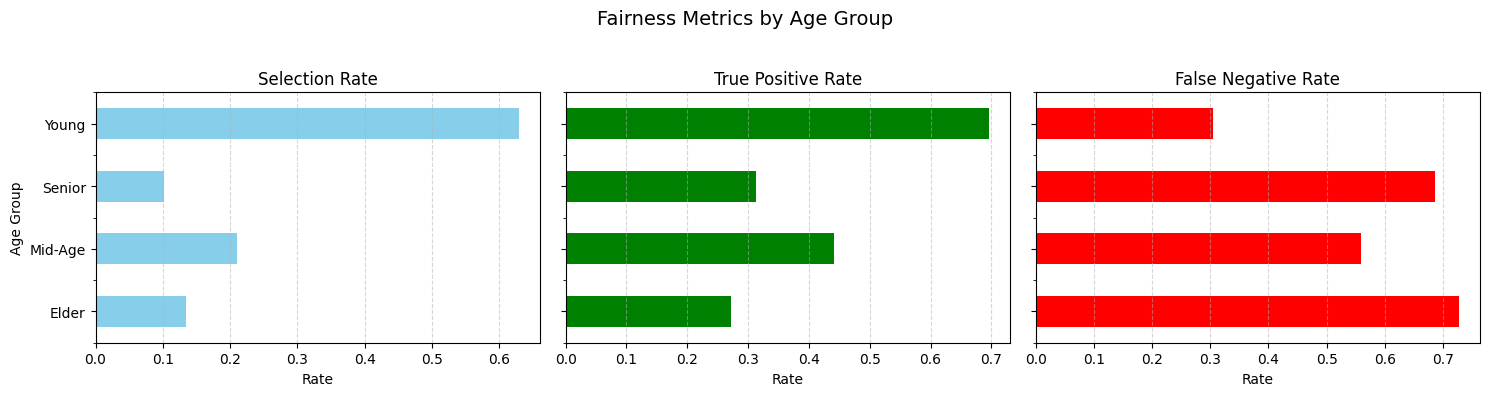

,Selection Rate,FNR,TPR
Age Group,,,
Elder,13.40%,72.73%,27.27%
Mid-Age,21.01%,55.93%,44.07%
Senior,10.10%,68.64%,31.36%
Young,62.86%,30.43%,69.57%


In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Data from fairness audit
data = {
    'Age Group': ['Elder', 'Mid-Age', 'Senior', 'Young'],
    'Selection Rate': [0.1340, 0.2101, 0.1010, 0.6286],
    'FNR': [0.7273, 0.5593, 0.6864, 0.3043],
    'TPR': [0.2727, 0.4407, 0.3136, 0.6957],
}

df = pd.DataFrame(data).set_index('Age Group')

# Plotting
disparity_sr = df['Selection Rate'].max() / df['Selection Rate'].min()
disparity_tpr = df['TPR'].max() / df['TPR'].min()
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
df['Selection Rate'].plot(kind='barh', ax=axes[0], color='skyblue')
axes[0].set_title('Selection Rate')
axes[0].invert_yaxis()

df['TPR'].plot(kind='barh', ax=axes[1], color='green')
axes[1].set_title('True Positive Rate')

df['FNR'].plot(kind='barh', ax=axes[2], color='red')
axes[2].set_title('False Negative Rate')

for ax in axes:
    ax.set_xlabel('Rate')
    ax.grid(True, axis='x', linestyle='--', alpha=0.5)

plt.suptitle('Fairness Metrics by Age Group', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Show raw table
display(df.style.format("{:.2%}"))
fig.savefig(
    "/Users/mlwu/Documents/Academia/CMU/tepper_courses/Ethics and AI/project/fig/fairness_dashboard.png",
    dpi=300,
    bbox_inches='tight'
)

## Future Directions

1. **Deploy CatBoost model for classification**
   - Final model demonstrated superior ROC AUC (0.823) and fairness-aware tradeoffs.

2. **Monitor feature drift and recall weekly**
   - Implement automated retraining alerts if performance or demographic parity shifts over time.

3. **Establish fairness thresholds using disaggregated metrics**
   - Current analysis reveals a **6.2× selection rate disparity** and **2.5× true positive rate disparity** between age groups.
   - Future updates should include:
     - Threshold calibration
     - Monotonic constraints by age
     - Regular subgroup fairness reports

4. **Disclose model logic and consent policies to customers**
   - Provide model explanations (e.g., SHAP) on demand.
   - Update Terms of Service with plain-language summaries of data use, revocable consent, and appeals rights.

5. **Visualize and audit fairness routinely**
   - Adopt dashboards (e.g., matplotlib-based) to track TPR/FNR gaps by age, gender, or ZIP code.
   - Report disparities that exceed policy-defined ethical thresholds.